<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

<font color="#d3d3d3"><h1><b>Reminder for all students and instructors to use the same version of the project notebooks (beginner or advanced)</b></h1></font>

![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)

In this notebook we will be:
1.   Visualizing Saliency Maps
2.   Evaluating our ML Models


# Milestone 1: Saliency maps

<font color="#de3023"><h2><b>Note: these blocks will take a minute to execute, so make sure to run them first thing!</b></h2></font>


In [1]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')
!pip install tf-keras-vis tensorflow

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]

    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_image(data, num_ims, figsize=(8,6), labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    print(data.shape)
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(-1,image_shape[0],image_shape[1],image_shape[2])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest

    nrows=int(np.sqrt(num_ims))
    ncols=int(np.ceil(num_ims/nrows))
    print(nrows,ncols)
    count=0
    if nrows==1 and ncols==1:
      print('Label: %s'%label)
      plt.imshow(image)
      plt.show()
    else:
      print(labels)
      fig = plt.figure(figsize=figsize)
      for i in range(nrows):
        for j in range(ncols):
          if count<num_ims:
            fig.add_subplot(nrows,ncols,count+1)
            plt.imshow(image[count])
            count+=1
      fig.set_size_inches(18.5, 10.5)
      plt.show()



  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))

    for layer in model.layers:
      if hasattr(layer,"activation"):
        stringlist.append(str(layer.activation))

    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
# image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
# metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

###
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data.npy'

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_image = lambda data, num_ims,figsize=(8,6), labels = [], index = None: helpers.plot_image(data = data, num_ims=num_ims, figsize=figsize,labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

#monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 5.8 MB/s eta 0:00:00
metadata.csv        100%[===================>] 200.33K   422KB/s    in 0.5s    
image_data.npy      100%[===================>] 423.61M  21.2MB/s    in 21s     


Before we get started, let's load in a CNN model as we did in the previous day. For convenience, we provide this code for you to get you started.

**Run the below code. You are now very familiar with this code!**

Epoch 1/50
201/211 [===========================>..] - ETA: 0s - loss: 1.3929 - accuracy: 0.2988

211/211 [==============================] - 6s 7ms/step - loss: 1.3908 - accuracy: 0.3009 - val_loss: 1.3605 - val_accuracy: 0.2522
Epoch 2/50
202/211 [===========================>..] - ETA: 0s - loss: 1.2892 - accuracy: 0.4016

211/211 [==============================] - 1s 4ms/step - loss: 1.2875 - accuracy: 0.4045 - val_loss: 1.3452 - val_accuracy: 0.2543
Epoch 3/50
204/211 [============================>.] - ETA: 0s - loss: 1.1918 - accuracy: 0.4746

211/211 [==============================] - 1s 5ms/step - loss: 1.1914 - accuracy: 0.4746 - val_loss: 1.3770 - val_accuracy: 0.2609
Epoch 4/50
205/211 [============================>.] - ETA: 0s - loss: 1.0800 - accuracy: 0.5384

211/211 [==============================] - 1s 5ms/step - loss: 1.0787 - accuracy: 0.5384 - val_loss: 1.4679 - val_accuracy: 0.2630
Epoch 5/50
211/211 [==============================] - ETA: 0s - loss: 0.9588 - accuracy: 0.6121

211/211 [==============================] - 1s 4ms/step - loss: 0.9588 - accuracy: 0.6121 - val_loss: 1.6233 - val_accuracy: 0.2761
Epoch 6/50
210/211 [============================>.] - ETA: 0s - loss: 0.8729 - accuracy: 0.6573

211/211 [==============================] - 1s 5ms/step - loss: 0.8729 - accuracy: 0.6570 - val_loss: 1.7474 - val_accuracy: 0.2859
Epoch 7/50
205/211 [============================>.] - ETA: 0s - loss: 0.7899 - accuracy: 0.6963

211/211 [==============================] - 1s 5ms/step - loss: 0.7870 - accuracy: 0.6971 - val_loss: 1.9893 - val_accuracy: 0.2957
Epoch 8/50
205/211 [============================>.] - ETA: 0s - loss: 0.7175 - accuracy: 0.7343

211/211 [==============================] - 1s 6ms/step - loss: 0.7155 - accuracy: 0.7360 - val_loss: 2.0967 - val_accuracy: 0.3022
Epoch 9/50
206/211 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.7647

211/211 [==============================] - 1s 6ms/step - loss: 0.6435 - accuracy: 0.7658 - val_loss: 2.3688 - val_accuracy: 0.2859
Epoch 10/50
207/211 [============================>.] - ETA: 0s - loss: 0.5927 - accuracy: 0.7905

211/211 [==============================] - 1s 5ms/step - loss: 0.5924 - accuracy: 0.7912 - val_loss: 2.5382 - val_accuracy: 0.2967
Epoch 11/50
208/211 [============================>.] - ETA: 0s - loss: 0.5461 - accuracy: 0.8148

211/211 [==============================] - 1s 5ms/step - loss: 0.5454 - accuracy: 0.8151 - val_loss: 2.5946 - val_accuracy: 0.3043
Epoch 12/50
204/211 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.8344

211/211 [==============================] - 1s 4ms/step - loss: 0.4960 - accuracy: 0.8357 - val_loss: 2.9463 - val_accuracy: 0.2891
Epoch 13/50
208/211 [============================>.] - ETA: 0s - loss: 0.4552 - accuracy: 0.8511

211/211 [==============================] - 1s 5ms/step - loss: 0.4565 - accuracy: 0.8507 - val_loss: 2.8826 - val_accuracy: 0.3109
Epoch 14/50
203/211 [===========================>..] - ETA: 0s - loss: 0.4197 - accuracy: 0.8665

211/211 [==============================] - 1s 4ms/step - loss: 0.4217 - accuracy: 0.8651 - val_loss: 2.8782 - val_accuracy: 0.3120
Epoch 15/50
199/211 [===========================>..] - ETA: 0s - loss: 0.3995 - accuracy: 0.8720

211/211 [==============================] - 1s 4ms/step - loss: 0.3977 - accuracy: 0.8730 - val_loss: 3.1833 - val_accuracy: 0.3065
Epoch 16/50
207/211 [============================>.] - ETA: 0s - loss: 0.3709 - accuracy: 0.8910

211/211 [==============================] - 1s 4ms/step - loss: 0.3685 - accuracy: 0.8920 - val_loss: 3.2015 - val_accuracy: 0.3065
Epoch 17/50
211/211 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8925

211/211 [==============================] - 1s 5ms/step - loss: 0.3495 - accuracy: 0.8925 - val_loss: 3.3880 - val_accuracy: 0.3000
Epoch 18/50
209/211 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8998

211/211 [==============================] - 1s 4ms/step - loss: 0.3326 - accuracy: 0.8999 - val_loss: 3.2658 - val_accuracy: 0.3163
Epoch 19/50
206/211 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.9119

211/211 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.9126 - val_loss: 3.5524 - val_accuracy: 0.3022
Epoch 20/50
211/211 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.9148

211/211 [==============================] - 1s 5ms/step - loss: 0.2890 - accuracy: 0.9148 - val_loss: 3.8414 - val_accuracy: 0.3022
Epoch 21/50
202/211 [===========================>..] - ETA: 0s - loss: 0.2677 - accuracy: 0.9242

211/211 [==============================] - 1s 6ms/step - loss: 0.2691 - accuracy: 0.9236 - val_loss: 3.9616 - val_accuracy: 0.2935
Epoch 22/50
210/211 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9259

211/211 [==============================] - 1s 5ms/step - loss: 0.2598 - accuracy: 0.9259 - val_loss: 3.8068 - val_accuracy: 0.3120
Epoch 23/50
211/211 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9359

211/211 [==============================] - 1s 4ms/step - loss: 0.2333 - accuracy: 0.9359 - val_loss: 3.9594 - val_accuracy: 0.3000
Epoch 24/50
200/211 [===========================>..] - ETA: 0s - loss: 0.2389 - accuracy: 0.9303

211/211 [==============================] - 1s 4ms/step - loss: 0.2375 - accuracy: 0.9304 - val_loss: 4.3646 - val_accuracy: 0.2859
Epoch 25/50
211/211 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9384

211/211 [==============================] - 1s 4ms/step - loss: 0.2269 - accuracy: 0.9384 - val_loss: 4.1520 - val_accuracy: 0.3033
Epoch 26/50
209/211 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9379

211/211 [==============================] - 1s 4ms/step - loss: 0.2184 - accuracy: 0.9377 - val_loss: 4.5521 - val_accuracy: 0.2772
Epoch 27/50
206/211 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9416

211/211 [==============================] - 1s 5ms/step - loss: 0.2077 - accuracy: 0.9419 - val_loss: 4.2233 - val_accuracy: 0.3054
Epoch 28/50
202/211 [===========================>..] - ETA: 0s - loss: 0.1901 - accuracy: 0.9462

211/211 [==============================] - 1s 4ms/step - loss: 0.1911 - accuracy: 0.9457 - val_loss: 4.5940 - val_accuracy: 0.2772
Epoch 29/50
202/211 [===========================>..] - ETA: 0s - loss: 0.1842 - accuracy: 0.9486

211/211 [==============================] - 1s 4ms/step - loss: 0.1840 - accuracy: 0.9488 - val_loss: 4.4115 - val_accuracy: 0.2978
Epoch 30/50
203/211 [===========================>..] - ETA: 0s - loss: 0.1853 - accuracy: 0.9467

211/211 [==============================] - 1s 4ms/step - loss: 0.1860 - accuracy: 0.9471 - val_loss: 4.3777 - val_accuracy: 0.3000
Epoch 31/50
206/211 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9565

211/211 [==============================] - 1s 4ms/step - loss: 0.1724 - accuracy: 0.9566 - val_loss: 4.7291 - val_accuracy: 0.2859
Epoch 32/50
204/211 [============================>.] - ETA: 0s - loss: 0.1641 - accuracy: 0.9577

211/211 [==============================] - 1s 5ms/step - loss: 0.1644 - accuracy: 0.9575 - val_loss: 4.5669 - val_accuracy: 0.3185
Epoch 33/50
206/211 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9560

211/211 [==============================] - 1s 6ms/step - loss: 0.1586 - accuracy: 0.9557 - val_loss: 4.6746 - val_accuracy: 0.2967
Epoch 34/50
203/211 [===========================>..] - ETA: 0s - loss: 0.1571 - accuracy: 0.9549

211/211 [==============================] - 1s 6ms/step - loss: 0.1572 - accuracy: 0.9549 - val_loss: 5.1930 - val_accuracy: 0.2761
Epoch 35/50
209/211 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9614

211/211 [==============================] - 1s 5ms/step - loss: 0.1503 - accuracy: 0.9615 - val_loss: 4.9758 - val_accuracy: 0.3000
Epoch 36/50
211/211 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9640

211/211 [==============================] - 1s 5ms/step - loss: 0.1376 - accuracy: 0.9640 - val_loss: 5.0174 - val_accuracy: 0.2793
Epoch 37/50
211/211 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9637

211/211 [==============================] - 1s 4ms/step - loss: 0.1429 - accuracy: 0.9637 - val_loss: 4.8159 - val_accuracy: 0.3076
Epoch 38/50
211/211 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9659

211/211 [==============================] - 1s 4ms/step - loss: 0.1326 - accuracy: 0.9659 - val_loss: 5.0495 - val_accuracy: 0.2935
Epoch 39/50
208/211 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9620

211/211 [==============================] - 1s 4ms/step - loss: 0.1334 - accuracy: 0.9621 - val_loss: 4.5069 - val_accuracy: 0.3120
Epoch 40/50
207/211 [============================>.] - ETA: 0s - loss: 0.1271 - accuracy: 0.9684

211/211 [==============================] - 1s 4ms/step - loss: 0.1267 - accuracy: 0.9685 - val_loss: 5.3557 - val_accuracy: 0.2891
Epoch 41/50
204/211 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9689

211/211 [==============================] - 1s 4ms/step - loss: 0.1183 - accuracy: 0.9691 - val_loss: 5.4041 - val_accuracy: 0.2772
Epoch 42/50
207/211 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9678

211/211 [==============================] - 1s 5ms/step - loss: 0.1210 - accuracy: 0.9682 - val_loss: 5.2510 - val_accuracy: 0.3033
Epoch 43/50
208/211 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9668

211/211 [==============================] - 1s 5ms/step - loss: 0.1193 - accuracy: 0.9670 - val_loss: 5.7477 - val_accuracy: 0.2728
Epoch 44/50
207/211 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9715

211/211 [==============================] - 1s 5ms/step - loss: 0.1086 - accuracy: 0.9713 - val_loss: 4.7408 - val_accuracy: 0.3174
Epoch 45/50
210/211 [============================>.] - ETA: 0s - loss: 0.1110 - accuracy: 0.9729

211/211 [==============================] - 2s 11ms/step - loss: 0.1110 - accuracy: 0.9729 - val_loss: 5.7346 - val_accuracy: 0.2902
Epoch 46/50
203/211 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9701

211/211 [==============================] - 2s 10ms/step - loss: 0.1101 - accuracy: 0.9709 - val_loss: 5.4500 - val_accuracy: 0.2989
Epoch 47/50
211/211 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9729

211/211 [==============================] - 2s 7ms/step - loss: 0.1024 - accuracy: 0.9729 - val_loss: 5.2892 - val_accuracy: 0.3109
Epoch 48/50
200/211 [===========================>..] - ETA: 0s - loss: 0.1087 - accuracy: 0.9709

211/211 [==============================] - 1s 5ms/step - loss: 0.1074 - accuracy: 0.9714 - val_loss: 5.4462 - val_accuracy: 0.3054
Epoch 49/50
211/211 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9723

211/211 [==============================] - 1s 4ms/step - loss: 0.1042 - accuracy: 0.9723 - val_loss: 5.7459 - val_accuracy: 0.2761
Epoch 50/50
208/211 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9761

211/211 [==============================] - 1s 5ms/step - loss: 0.0959 - accuracy: 0.9759 - val_loss: 5.7241 - val_accuracy: 0.2924
Epoch 1/50
211/211 [==============================] - ETA: 0s - loss: 1.3752 - accuracy: 0.3199

211/211 [==============================] - 9s 10ms/step - loss: 1.3752 - accuracy: 0.3199 - val_loss: 1.3647 - val_accuracy: 0.3739
Epoch 2/50
206/211 [============================>.] - ETA: 0s - loss: 1.1902 - accuracy: 0.5140

211/211 [==============================] - 2s 7ms/step - loss: 1.1869 - accuracy: 0.5140 - val_loss: 1.1250 - val_accuracy: 0.5315
Epoch 3/50
206/211 [============================>.] - ETA: 0s - loss: 0.8335 - accuracy: 0.6352

211/211 [==============================] - 2s 7ms/step - loss: 0.8294 - accuracy: 0.6373 - val_loss: 1.1563 - val_accuracy: 0.5522
Epoch 4/50
208/211 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.7106

211/211 [==============================] - 2s 8ms/step - loss: 0.6505 - accuracy: 0.7112 - val_loss: 1.2258 - val_accuracy: 0.5511
Epoch 5/50
205/211 [============================>.] - ETA: 0s - loss: 0.5460 - accuracy: 0.7655

211/211 [==============================] - 2s 7ms/step - loss: 0.5448 - accuracy: 0.7661 - val_loss: 1.5612 - val_accuracy: 0.5130
Epoch 6/50
209/211 [============================>.] - ETA: 0s - loss: 0.4731 - accuracy: 0.8086

211/211 [==============================] - 2s 8ms/step - loss: 0.4724 - accuracy: 0.8090 - val_loss: 1.9506 - val_accuracy: 0.4880
Epoch 7/50
209/211 [============================>.] - ETA: 0s - loss: 0.4170 - accuracy: 0.8436

211/211 [==============================] - 2s 9ms/step - loss: 0.4165 - accuracy: 0.8438 - val_loss: 1.3744 - val_accuracy: 0.5413
Epoch 8/50
209/211 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8695

211/211 [==============================] - 1s 7ms/step - loss: 0.3588 - accuracy: 0.8696 - val_loss: 1.8226 - val_accuracy: 0.4870
Epoch 9/50
205/211 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.9000

211/211 [==============================] - 2s 7ms/step - loss: 0.3057 - accuracy: 0.8996 - val_loss: 1.1533 - val_accuracy: 0.5457
Epoch 10/50
204/211 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9217

211/211 [==============================] - 2s 8ms/step - loss: 0.2544 - accuracy: 0.9213 - val_loss: 1.9983 - val_accuracy: 0.5141
Epoch 11/50
209/211 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9344

211/211 [==============================] - 2s 8ms/step - loss: 0.2114 - accuracy: 0.9346 - val_loss: 1.8307 - val_accuracy: 0.4967
Epoch 12/50
206/211 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9442

211/211 [==============================] - 2s 7ms/step - loss: 0.1841 - accuracy: 0.9444 - val_loss: 1.3173 - val_accuracy: 0.6239
Epoch 13/50
208/211 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9455

211/211 [==============================] - 1s 7ms/step - loss: 0.1658 - accuracy: 0.9456 - val_loss: 1.6746 - val_accuracy: 0.5152
Epoch 14/50
208/211 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9551

211/211 [==============================] - 2s 9ms/step - loss: 0.1434 - accuracy: 0.9540 - val_loss: 1.7026 - val_accuracy: 0.5120
Epoch 15/50
206/211 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9636

211/211 [==============================] - 2s 9ms/step - loss: 0.1199 - accuracy: 0.9640 - val_loss: 1.6112 - val_accuracy: 0.5315
Epoch 16/50
211/211 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9686

211/211 [==============================] - 2s 8ms/step - loss: 0.1125 - accuracy: 0.9686 - val_loss: 1.8380 - val_accuracy: 0.5261
Epoch 17/50
209/211 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9699

211/211 [==============================] - 2s 8ms/step - loss: 0.1007 - accuracy: 0.9698 - val_loss: 1.8866 - val_accuracy: 0.5283
Epoch 18/50
206/211 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9748

211/211 [==============================] - 2s 8ms/step - loss: 0.0827 - accuracy: 0.9747 - val_loss: 2.0011 - val_accuracy: 0.5033
Epoch 19/50
206/211 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9765

211/211 [==============================] - 2s 7ms/step - loss: 0.0790 - accuracy: 0.9765 - val_loss: 2.0415 - val_accuracy: 0.5261
Epoch 20/50
207/211 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9795

211/211 [==============================] - 2s 8ms/step - loss: 0.0689 - accuracy: 0.9795 - val_loss: 1.6641 - val_accuracy: 0.5457
Epoch 21/50
210/211 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9798

211/211 [==============================] - 2s 8ms/step - loss: 0.0616 - accuracy: 0.9798 - val_loss: 1.9957 - val_accuracy: 0.5609
Epoch 22/50
207/211 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9834

211/211 [==============================] - 2s 10ms/step - loss: 0.0537 - accuracy: 0.9835 - val_loss: 1.9050 - val_accuracy: 0.5641
Epoch 23/50
207/211 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9846

211/211 [==============================] - 2s 8ms/step - loss: 0.0533 - accuracy: 0.9845 - val_loss: 2.3214 - val_accuracy: 0.5033
Epoch 24/50
211/211 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9859

211/211 [==============================] - 2s 8ms/step - loss: 0.0486 - accuracy: 0.9859 - val_loss: 2.3137 - val_accuracy: 0.5446
Epoch 25/50
210/211 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9869

211/211 [==============================] - 2s 7ms/step - loss: 0.0435 - accuracy: 0.9869 - val_loss: 2.2725 - val_accuracy: 0.5435
Epoch 26/50
204/211 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9882

211/211 [==============================] - 2s 7ms/step - loss: 0.0374 - accuracy: 0.9878 - val_loss: 2.6843 - val_accuracy: 0.4978
Epoch 27/50
207/211 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9870

211/211 [==============================] - 2s 7ms/step - loss: 0.0389 - accuracy: 0.9869 - val_loss: 2.6511 - val_accuracy: 0.5054
Epoch 28/50
209/211 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9883

211/211 [==============================] - 2s 7ms/step - loss: 0.0343 - accuracy: 0.9884 - val_loss: 2.6604 - val_accuracy: 0.5120
Epoch 29/50
207/211 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9899

211/211 [==============================] - 2s 10ms/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 2.4182 - val_accuracy: 0.5837
Epoch 30/50
208/211 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.9901

211/211 [==============================] - 2s 9ms/step - loss: 0.0322 - accuracy: 0.9902 - val_loss: 2.2499 - val_accuracy: 0.5315
Epoch 31/50
204/211 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9916

211/211 [==============================] - 2s 8ms/step - loss: 0.0255 - accuracy: 0.9915 - val_loss: 2.3108 - val_accuracy: 0.5065
Epoch 32/50
208/211 [============================>.] - ETA: 0s - loss: 0.0240 - accuracy: 0.9923

211/211 [==============================] - 2s 7ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 2.3965 - val_accuracy: 0.5337
Epoch 33/50
207/211 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9952

211/211 [==============================] - 2s 7ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 2.7676 - val_accuracy: 0.5315
Epoch 34/50
209/211 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9930

211/211 [==============================] - 2s 8ms/step - loss: 0.0205 - accuracy: 0.9927 - val_loss: 2.7473 - val_accuracy: 0.5315
Epoch 35/50
204/211 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9949

211/211 [==============================] - 2s 8ms/step - loss: 0.0170 - accuracy: 0.9948 - val_loss: 2.6222 - val_accuracy: 0.5370
Epoch 36/50
208/211 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9950

211/211 [==============================] - 2s 9ms/step - loss: 0.0138 - accuracy: 0.9951 - val_loss: 3.2110 - val_accuracy: 0.5109
Epoch 37/50
206/211 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9948

211/211 [==============================] - 2s 10ms/step - loss: 0.0145 - accuracy: 0.9948 - val_loss: 3.4543 - val_accuracy: 0.5130
Epoch 38/50
208/211 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9961

211/211 [==============================] - 2s 8ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 2.6923 - val_accuracy: 0.5359
Epoch 39/50
211/211 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9960

211/211 [==============================] - 2s 7ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 3.0984 - val_accuracy: 0.5261
Epoch 40/50
205/211 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9963

211/211 [==============================] - 2s 7ms/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 3.1143 - val_accuracy: 0.4935
Epoch 41/50
207/211 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9958

211/211 [==============================] - 2s 8ms/step - loss: 0.0113 - accuracy: 0.9958 - val_loss: 3.3747 - val_accuracy: 0.5011
Epoch 42/50
205/211 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9979

211/211 [==============================] - 2s 8ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 3.2172 - val_accuracy: 0.5435
Epoch 43/50
210/211 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9966

211/211 [==============================] - 2s 9ms/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 2.9197 - val_accuracy: 0.5337
Epoch 44/50
207/211 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9976

211/211 [==============================] - 2s 10ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 4.2096 - val_accuracy: 0.4772
Epoch 45/50
209/211 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9958

211/211 [==============================] - 2s 7ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 3.0573 - val_accuracy: 0.5228
Epoch 46/50
205/211 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9968

211/211 [==============================] - 1s 7ms/step - loss: 0.0082 - accuracy: 0.9969 - val_loss: 3.3137 - val_accuracy: 0.5837
Epoch 47/50
211/211 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9973

211/211 [==============================] - 2s 7ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 3.4232 - val_accuracy: 0.5272
Epoch 48/50
205/211 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

211/211 [==============================] - 2s 8ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 4.4091 - val_accuracy: 0.4663
Epoch 49/50
211/211 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9979

211/211 [==============================] - 2s 8ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 3.3520 - val_accuracy: 0.5337
Epoch 50/50
205/211 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9980

211/211 [==============================] - 2s 8ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 2.9030 - val_accuracy: 0.5630
Dense


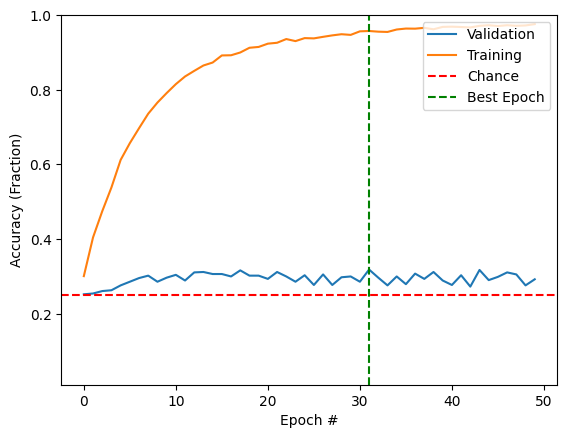

CNN


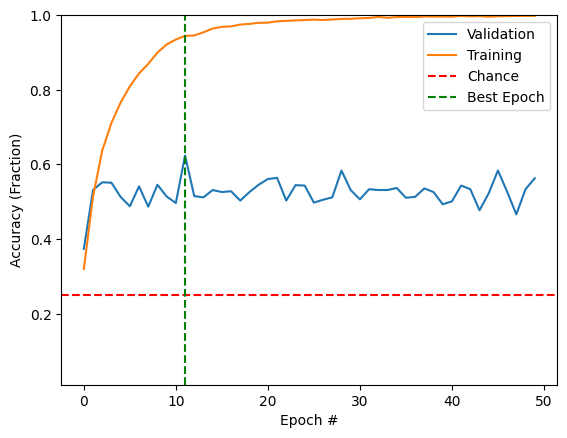

In [2]:
train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

dense = DenseClassifier(hidden_layer_sizes = (128,64))
cnn = CNNClassifier(num_hidden_layers = 5)

dense.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

print('Dense')
plot_acc(dense.history)

print('CNN')
plot_acc(cnn.history)

Now, let's view the saliency map of several of our images. A saliency map is used to visualize which pixels in an input image are the most influential, or **salient**, when the network is making a decision. In other words, this means that we can show which pixels in the input image the network is looking at when classifying an image.

One way to do this is by calculating the gradient on each pixel with respect to a given class score; that gradient will be steeper for pixels that influence the output a lot, and lower for pixels that didn't have much to do with the classification the model makes. (If this sounds familiar to you, you might be thinking of **backpropagation**, where a neural network corrects itself based on how much each node influences loss. They are similar in concept but not the same! If you are interested in learning about more about backpropagation, [this article](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd) is a good resource.)

In the following example, we show an photo of a tabby cat, and we're interested in which pixels were most important for the model when recognizing the cat. The pixels that were most important to the model will show up on a heatmap with warmer colors. This is one example of a **saliency map**.

![saliency_map](https://i.ibb.co/ygBG5Sb/tabby-heatmap.png)

If you want to explore saliency maps more, check out [this website](https://lrpserver.hhi.fraunhofer.de/image-classification) for an interactive demo.

In [3]:
#@title Run this to prepare your saliency map visualization tools!
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

# save string versions of labels
train_labels_strings = train_labels
test_labels_strings = test_labels

# convert labels into numpy vectors (one-hot encoding!)
train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

replace2linear = ReplaceToLinear()

images = []
for i, title in enumerate(test_labels_strings):
  dim = (64, 64)
  img = np.array(cv2.resize(test_data[i], dim))
  images.append(img)
images = np.asarray(images)

def getImageSamples():
  image_samples = []
  image_samples_labels = []
  idx = random.randint(0, 230)
  for i in range(4):
    image_samples.append(images[idx])
    image_samples_labels.append(test_labels_strings[idx])
    idx = idx + 230
  image_samples = np.asarray(image_samples)
  return image_samples, image_samples_labels

def plot_vanilla_saliency_of_a_model(model, X_input, image_titles):
    score = CategoricalScore(list(range(X_input.shape[0])))

    # Create Saliency visualization object
    saliency = Saliency(model,
                        model_modifier=ReplaceToLinear(), # replaces the activation function of the chosen layer (here is the last layer) to linear function (for visualization)
                        clone=True)

    # Generate saliency map
    saliency_map = saliency(score, X_input)

    # Rendering
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(X_input[i])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Plot saliencies
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(saliency_map[i], cmap='jet')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

## Exercise: Saliency Map

Run this cell to view a saliency map for images from each distinct class.

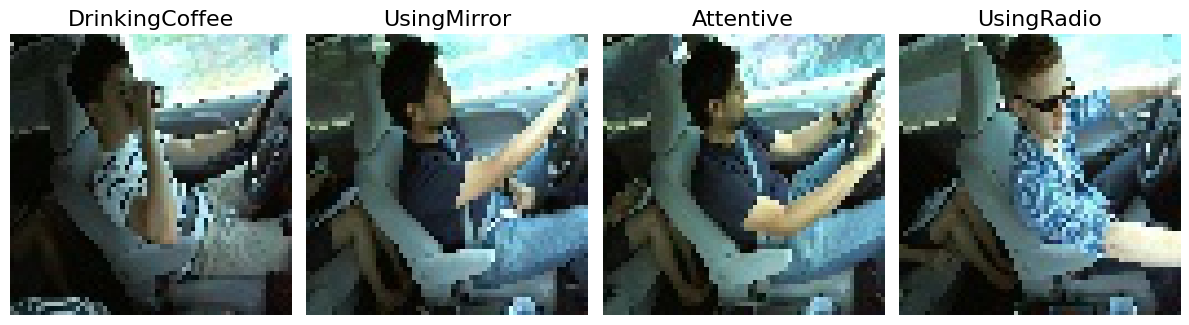

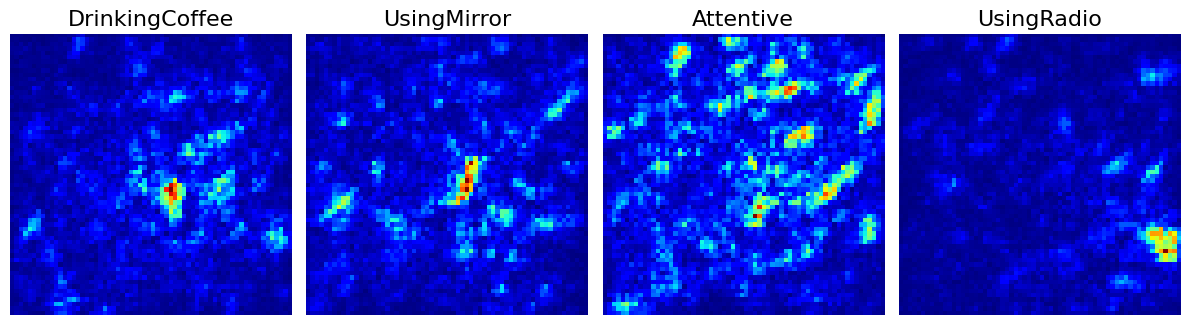

In [4]:
imgs, imgs_labels = getImageSamples()
plot_vanilla_saliency_of_a_model(cnn, imgs, imgs_labels)

## Instructor-Led Discussion: Saliency maps

With your group, discuss:

**What differences do you notice between the saliency maps of the different classes?**

**What might be the underlying cause of these differences?**

## Optional Exercise: Saliency of your custom CNNs.

Develop your own custom CNN architectures in Keras/Tensorflow and see how their visual saliencies may differ across images.

In [ ]:
### YOUR CODE HERE

### END CODE

# Milestone 2: Model Evaluation

## Activity 2a. How did we do on predicting distracted drivers?

In [5]:
#@title Run this cell to import and train the VGG16 model

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.applications.vgg16 import VGG16

# get data
train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

# save string versions of labels
train_labels_strings = train_labels
test_labels_strings = test_labels

# convert labels into numpy vectors (one-hot encoding!)
train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

from tensorflow.keras.applications.vgg16 import VGG16

# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4, activation = 'softmax'))

# finally, we build the vgg model and turn it on so we can use it!
vgg_model.compile(loss = 'categorical_crossentropy',
          optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
          metrics=['accuracy'])

# grab our augmented training manual
# and hand it to our model to train
vgg_model.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True)


58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
211/211 [==============================] - 17s 62ms/step - loss: 1.0024 - accuracy: 0.5494 - val_loss: 0.7217 - val_accuracy: 0.7065
Epoch 2/10
211/211 [==============================] - 11s 54ms/step - loss: 0.1541 - accuracy: 0.9537 - val_loss: 0.7762 - val_accuracy: 0.7663
Epoch 3/10
211/211 [==============================] - 11s 54ms/step - loss: 0.0900 - accuracy: 0.9746 - val_loss: 0.9344 - val_accuracy: 0.7217
Epoch 4/10
211/211 [==============================] - 12s 55ms/step - loss: 0.0472 - accuracy: 0.9871 - val_loss: 1.4549 - val_accuracy: 0.5826
Epoch 5/10
211/211 [==============================] - 12s 55ms/step - loss: 0.0364 - accuracy: 0.9906 - val_loss: 1.0119 - val_accuracy: 0.6804
Epoch 6/10
211/211 [==============================] - 11s 54ms/step - loss: 0.0239 - accuracy: 0.9939 - val_loss: 2.0687 - val_accuracy: 0.5413
Epoch 7/10
211/211 [==============================] - 11s 54ms/step - l

### Exercise (Coding) | Within a student group

Use your best model from yesterday and train it again.

In [ ]:
### YOUR CODE HERE

### END CODE

As we learned last week, total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models.

In the case of detection of unsafe driving, we may be more interested in other quantities, such as 'how accurate were we on the distracted images?' or 'how accurate were we on the attentive category?' or 'how much of the attentive drivers were confused for distracted driving?' or vice versa.



Our metrics for classification can be described in terms of a 'confusion matrix', shown below.

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Distracted Driving (DrinkingCoffee, UsingMirror, or UsingRadio) = 1/Positive and Attentive = 0/Negative, then...

* True positive: True distracted driving prediction: Distracted driving predicted as distracted driving
* True negative: True attentive prediction: Attentive predicted as attentive
* False positive: False distracted driving prediction: Attentive mistaken as distracted driving
* False negative: False attentive prediction: Distracted driving mistaken as attentive


The `sklearn` package makes calculating confusion matrices very quick! Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - DISTRACTED DRIVING or 0 - ATTENTIVE)
* `predictions`: what our model thinks the labels are

To get `predictions`, we have to give our model our `test_data`, and ask it to give us `predictions`. We'll do that with

```
predictions = np.argmax(vgg_model.predict(test_data), axis=-1)
```

In [7]:
predictions = vgg_model.predict(test_data)
predictions = np.argmax(predictions,axis=1)

29/29 [==============================] - 1s 15ms/step


## Exercise: Confusion matrix for distracted vs. non-distracted driving

First, write code below to calculate the accuracy of the classifier. Note that to complete this, you will need to transform the current 4-way classification into a binary (2-way) classification. That is, we will group all of UsingRadio, UsingMirror, and DrinkingCoffee into a single class representing all of distracted driving in general.

In [8]:
### YOUR CODE HERE

# First, covert all of the labels to numbers.
# If the true label corresponds to Attentive (e.g., the vector looks like
# [1, 0, 0, 0]), then we add 0 (for attentive) to final_labels. Otherwise,
# for the vectors [0, 1, 0, 0], [0, 0, 1, 0], and [0, 0, 0, 1], we add a label
# of 1 (for distracted).
final_labels = []
for label in test_labels:
 if label[0]==1:
    final_labels.append(0)
 else:
  final_labels.append(1)
# FILL IN THIS LOOP

# Now, we change our final predictions to 0 and 1. That is, if the predictions
# currently is 0, then add 0 (for attentive) to binary_predictions. Otherwise,
# add 1.
binary_predictions = []
for label in predictions:
  if label==1:
    binary_predictions.append(0)
  else:
    binary_predictions.append(1)

  # FILL IN THIS LOOP

print('Accuracy is %d %%'%(accuracy_score(final_labels, binary_predictions)*100.0))

### END CODE

Accuracy is 67 %


### Discuss: Is this good accuracy?

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(final_labels, binary_predictions)
print(confusion)

tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

We can visualize the confusion matrix with seaborn to make it easier for our eyes...

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

### Exercise (Discussion)

**Discuss with your instructor what you got and also...**

What is more problematic? False positives or False negatives?

Which of these metrics do we want to keep low?


## Exercise: Precision and Recall Calculation

Recall our discussion of precision and recall. Discuss with the course the difference between precision and recall. Then, print the precision and recall of the model and discuss with the class the implications of precision and recall in terms of distracted driving.

In [ ]:
## YOUR CODE HERE

## END CODE


### Optional Exercise (Coding) | In group



If you're interested, you can try to calculate true/false positive/negative with your own code! Then, check how you did by comparing to the `sklearn.metrics` confusion matrix results.

Hint:
* `predictions` is an np array that looks like... `[1, 0, 0, 1, ...]`
* `test_labels` is an np array looks like... `[1, 0, 0, 1, ...]`

In [ ]:
### YOUR CODE HERE

### END CODE

To recap, we built neural network models to see if we can do better than our simple logistic regression. It turns out that we can! And, also, by introducing convolutions to our networks (making the convolutional neural networks), we can improve by quite a lot. Finally, we employed pretrained 'expert' models to boost our performance even further.

# Challenge Exercise: Maintaining Privacy

A common problem in video recording is maintaining privacy of users. If you have time, add privacy to all of our training and test data by modifying the images to have red boxes over the faces. Then, retrain the CNN and evaluate the performance.

In [ ]:
### YOUR CODE HERE

### END CODE

# Fin!
